# tile llc model run and distribute parcels runs

J'ai balisé avec deux étoiles (`**`) les parties qui vont sûrement nécessiter des modifs.

Le code principal est dans le [fichier suivant](https://github.com/apatlpo/mit_equinox/blob/master/mitequinox/parcels.py)

- [ ] créer le bon environnement, cf [conda.md](https://github.com/apatlpo/mit_equinox/blob/master/doc/conda.md). Ne pas oublier de mettre à jour les fichiers dans `.dask/config/`
- [ ] parcours ce notebook pour comprendre ce qui est fait
- [ ] Finish implementing main loop around step_window (à la fin)
- [ ] verify particles transition smoothly from one grid to the next (pas du tout testé, peut-être gros morceau)
- [ ] verify what happens when a particle hit the limit of a tile: il faudrait comprendre ce que parcels fait. Je pense que les flotteurs disparaissent. Il faudrait donc trouver un moyen de les récupérer. Cela va sûrement nécessiter de relancer une (des) simulations sur la fenêtre temporelle concernée et sur le nouveau tile dans lequel le flotteur est arrivé.
- [ ] try to speed llc tiling file writing (persist dataset first)
- [ ] adjust tile size and overlap if necessary (may have to wait full dataset runs)
- [ ] run particle simulation on full dataset (pas du tout testé, peut-être gros morceau)
- [ ] try to change time stepping scheme: RK4
- [ ] write a function to load dataset into xarray or dask.dataframe


In [1]:
import os, shutil
from tqdm import tqdm

import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime
import geopandas

import dask
from dask.delayed import delayed

%matplotlib inline
from matplotlib import pyplot as plt

import xgcm

from parcels import FieldSet, ParticleSet, ParticleFile, plotTrajectoriesFile
from parcels import JITParticle, ScipyParticle
from parcels import ErrorCode, NestedField, AdvectionEE, AdvectionRK4

import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
# ** processes and cores may be adjusted in order to have more memory or inversely more computational ressource
cluster = PBSCluster(processes=4, cores=4, walltime='04:00:00')
#cluster = PBSCluster()
w = cluster.scale(jobs=5)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.37:58685 Dashboard: http://10.148.0.37:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
## setup directories and run parameters

In [3]:
root_dir = ut.root_data_dir+'parcels/' # ** utiliser le scratch plutôt?

run_name = 'test'
overwrite = True

# create or overwrite run_dir
run_dir = root_dir+run_name
if os.path.isdir(run_dir):
    if overwrite:
        shutil.rmtree(run_dir)
        os.mkdir(run_dir)
    else:
        #assert False, 'You need to archive the following directory:\n'+run_dir
        pass
else:
    os.mkdir(run_dir)

tile_dir = os.path.join(run_dir,'tiling/')

In [4]:
# simulation parameters

#T = 360? # length of the total run [days]
T = 20 # ** debug
#dt_windows = 5 # time window
dt_windows = 2 # ** debug, 5j devrait être plus approprié je pense
dt_stepping = 1 # hours
dt_outputs = 1 # hours

dij_init = 10 # initial position subsampling compared to llc grid

---

## create tiles

This could be done somewhere else, in another notebook

See `rearrange.ipynb` and `tile.ipynb` for more details

** Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant

In [5]:
create_tiles = True

if create_tiles:

    # load llc data
    ds = ut.load_data(V=['SST', 'SSU', 'SSV'])
    grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
    ds = xr.merge([ds, grd])
    
    # ** could filter out tiles that are empty, criterium on Depth or SST should be sufficient

    # create tiler
    tl = pa.tiler(ds=grd.reset_coords(), factor=(10, 10), overlap=(100, 100))
    # store tiler
    tl.store(tile_dir)
    
else:
    
    #tile_dir = root_dir+''
    tile_dir = ut.root_data_dir+'parcels/tiling/'
    tl = pa.tiler(tile_dir=tile_dir)
    

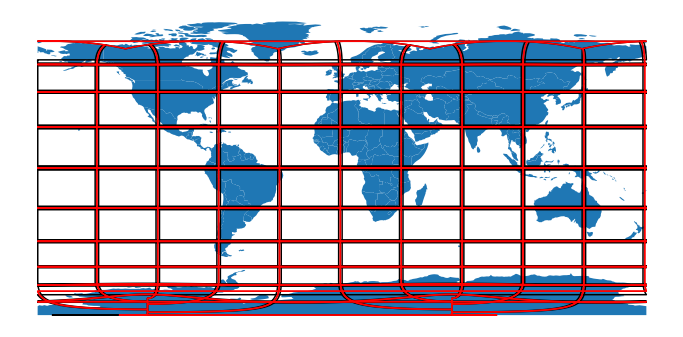

In [6]:
crs = tl.crs_wgs84

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
new_world = world.to_crs(crs)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
new_world.plot(ax=ax)
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color="black")
for b in tl.G['boundaries']:
    b.to_crs(crs).boundary.plot(ax=ax, color="red")
ax.set_axis_off()
plt.show()

In [ ]:
# create a tree of directories to store data
tile_data_dirs = [os.path.join(run_dir,'data_{:03d}'.format(t)) for t in range(tl.N_tiles)]
for t in tile_data_dirs:
    os.mkdir(t)

---

## !!Not used for now!! 

initial distribution of floats is performed within `step_window` now.

We start from llc grid

In [ ]:
dij = 100 # 1 float every 10 grid points
x = (grd[['XC','YC']]
          .isel(i=slice(0,None,dij), j=slice(0,None,dij))
          .stack(drifter=('i','j','face'))
          .reset_coords()
         )
x = x.where(x.Depth>0, drop=True).persist()

x.plot.scatter(x='XC', y='YC', hue='Depth', s=2, size=10)

In [ ]:
# assign to tiles
#df_tiles = tl.assign(lon=x_init.XC, lat=x_init.YC)

# distributed version
def assign(lon, lat):
    #import mitequinox.parcels as pa
    #tile_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/tiling/'
    tl = pa.tiler(tile_dir=tile_dir)
    df = tl.assign(lon=lon.squeeze(), lat=lat.squeeze())
    return df.values

x['tiles'] = xr.apply_ufunc(assign, 
                            x.XC, x.YC, 
                            dask='parallelized', 
                            output_dtypes=[int]
                           ).persist()

In [ ]:
%time x.plot.scatter(x='XC', y='YC', hue='tiles', s=3, size=10, vmin=0, vmax=tl.N_tiles)
# dij=100, single node: 1 min35s
# dij=100, 5x(4,4) cluster: 2 min 5s

In [ ]:
# drop -1 (drifter without box)
x = x.where(x.tiles>-1, drop=True)

In [ ]:
x = (x
     .rename({'XC': 'lon', 'YC': 'lat'})
     .drop_vars(['CS','SN','rA'])
    )

In [ ]:
# store in file to be processed
def store_floats_init(x):
    ''' store initial float positions
    '''
    tile = int(x.tiles.values[0])
    x = x.chunk({'drifter': -1}).reset_index('drifter')
    x.to_netcdf(os.path.join(tile_data_dirs[tile], 'x_init.nc'), mode='w')
    return x.mean(dim='drifter')

x_mean = x.groupby('tiles').apply(store_floats_init)
x_mean.lon.plot()

--- 

## tests on one window


### rewrite llc data into tiles

In [13]:
# store data, may not be necessary eventually

# Note:inspection of dash board confirms data for each tile is spread all over workers
# we may be able to do better by assigning each tile objects to a worker
#    see https://distributed.dask.org/en/latest/locality.html#user-control

def tile_store_llc(t):
    
    tslice = slice(t, t+dt_windows*24, None)
    ds_tsubset = ds.isel(time=tslice) # ** should try to persist here, but fails right now

    D = tl.tile(ds_tsubset, persist=False)
    #rechunk={'time': 2}

    for tile, ds_tile in enumerate(tqdm(D)):
        # i_g -> i, j->j_g
        ds_tile = pa.fuse_dimensions(ds_tile)
        #
        nc_file = os.path.join(tile_data_dirs[tile], 'llc.nc')
        ds_tile.to_netcdf(nc_file)

tile_store_llc(0)
# does not go through if data has been persisted before hand !? bizar
# we are probably creating more data reads than necessary with the present solution

# dt_windows = 5d, 10x10 tiles, 5 workers: 30min

# dt_windows = 10d, 10x10 tiles, 5 workers: 50min
# dt_windows = 10d, 10x10 tiles, 10 workers: 50min

# increasing number of workers does not help: disk access is probably the limiting factor

100%|██████████| 100/100 [12:05<00:00,  7.26s/it]


In [ ]:
# same but not working, reasons unclear, we may be asking too much to the scheduler 
# as data is spread over all workers
if False:
    # with D items (tiles) persisted
    delayed_results = []
    for tile, ds_tile in enumerate(D):
        nc_file = os.path.join(tile_data_dirs[tile], 'llc.nc')
        delayed = ds_tile.to_netcdf(nc_file, compute=False)
        delayed_results.append(delayed)
        
    results = dask.compute(*delayed_results)

### distribute parcels computations over tiles

In [7]:
step = 0
dij = 10
dsteps = [delayed(pa.step_window)(tile, step, dt_windows, tl, run_dir,
                                  init_dij=dij, 
                                  parcels_remove_on_land=True,
                                 ) 
          for tile in range(tl.N_tiles)
         ]
dsteps_out = dask.compute(*dsteps)

In [10]:
# test on one tile
#psize = pa.step_window(5,0, dt_windows, tl, run_dir)

--- 

## loop over time windows (main loop)

** we will probably need a restart mechanism the loop from a given time, it may be as simple as changing `np.arange(0,T, dt_windows)` into `np.arange(t_restart,T, dt_windows)`

** we may need to manually clear memory (for example if llc dataset has been persisted during tile_store_llc)


In [ ]:
dij = 10

for step, t in enumerate(np.arange(0,T, dt_windows)):
    
    # load, tile and store llc data
    tile_store_llc(t)
        
    # distribute parcels computations
    dsteps = [delayed(pa.step_window)(tile, step, dt_windows, tl, run_dir,
                                  init_dij=dij, 
                                  parcels_remove_on_land=True,
                                 ) 
              for tile in range(tl.N_tiles)
             ]
    dsteps_out = dask.compute(*dsteps)    
    
    # ** remove data from memory manually

---
## load dataset and plot a subset of trajectories

In [ ]:
# ds = xr.open_mfdataset(...)

---

In [ ]:
cluster.close()